## 0. Libarary 불러오기

In [1]:
import os, glob
import time
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize
from torchvision.models import resnet50, resnext50_32x4d, resnet18, resnext101_32x8d

from torchsummary import summary
import torch_optimizer as optim
from torchsampler import ImbalancedDatasetSampler
from catalyst.data import BalanceClassSampler

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [2]:
%matplotlib inline 

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:0


## 1. 데이터셋 정의

### (1) Train Dataset

In [4]:
# 학습 데이터셋 폴더 경로를 지정해주세요.
train_dir = '/opt/ml/input/data/train'
trainimage_dir = os.path.join(train_dir, 'images')

In [5]:
# meta 데이터와 이미지 경로를 불러옵니다.
train_df = pd.read_csv(os.path.join(train_dir, 'train.csv'))
train_df

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59
...,...,...,...,...,...
2695,006954,male,Asian,19,006954_male_Asian_19
2696,006955,male,Asian,19,006955_male_Asian_19
2697,006956,male,Asian,19,006956_male_Asian_19
2698,006957,male,Asian,20,006957_male_Asian_20


In [ ]:
masks = ['mask1', 'mask2', 'mask3', 'mask4', 'mask5', 'incorrect_mask', 'normal']
wears = ['Wear', 'Wear', 'Wear', 'Wear', 'Wear', 'Incorrect', 'Not Wear']
mask_df = pd.DataFrame()
for person in train_df.values:
    for mask, wear in zip(masks, wears):
        mask_df = mask_df.append(pd.Series(np.append(person, (mask, wear))), ignore_index=True)
mask_df.columns = np.append(train_df.columns.values, ('mask', 'wear'))
mask_df

,id,gender,race,age,path,mask,wear
0,000001,female,Asian,45.0,000001_female_Asian_45,mask1,Wear
1,000001,female,Asian,45.0,000001_female_Asian_45,mask2,Wear
2,000001,female,Asian,45.0,000001_female_Asian_45,mask3,Wear
3,000001,female,Asian,45.0,000001_female_Asian_45,mask4,Wear
4,000001,female,Asian,45.0,000001_female_Asian_45,mask5,Wear
...,...,...,...,...,...,...,...
18895,006959,male,Asian,19.0,006959_male_Asian_19,mask3,Wear
18896,006959,male,Asian,19.0,006959_male_Asian_19,mask4,Wear
18897,006959,male,Asian,19.0,006959_male_Asian_19,mask5,Wear
18898,006959,male,Asian,19.0,006959_male_Asian_19,incorrect_mask,Incorrect


In [ ]:
mask_df = mask_df.sample(frac=1).reset_index(drop=True)
mask_df

,id,gender,race,age,path,mask,wear
0,003596,female,Asian,59.0,003596_female_Asian_59,mask2,Wear
1,003424,female,Asian,54.0,003424_female_Asian_54,mask5,Wear
2,004385,male,Asian,60.0,004385_male_Asian_60,mask1,Wear
3,003850,female,Asian,47.0,003850_female_Asian_47,mask4,Wear
4,003799,female,Asian,54.0,003799_female_Asian_54,mask1,Wear
...,...,...,...,...,...,...,...
18895,006713,male,Asian,19.0,006713_male_Asian_19,incorrect_mask,Incorrect
18896,001593,female,Asian,60.0,001593_female_Asian_60,incorrect_mask,Incorrect
18897,003333,female,Asian,19.0,003333_female_Asian_19,mask5,Wear
18898,001639,male,Asian,18.0,001639_male_Asian_18,mask3,Wear


In [ ]:
train, valid = train_test_split(mask_df, test_size=0.2, stratify=mask_df['wear'])
print(f'Train Set dim : (%d, %d)' % (train.shape))
print(f'Valid Set dim : (%d, %d)' % (valid.shape))

Train Set dim : (15120, 7)
Valid Set dim : (3780, 7)


In [13]:
transform = transforms.Compose([
    Resize((224, 224), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
])

In [43]:
class TrainDataset(Dataset):
    def __init__(self, path, mask_df, transform):
        super(TrainDataset).__init__()
        self.path = path
        self.mask_df = mask_df
        self.transform = transform
        
    def __getitem__(self, idx):
        full_path = os.path.join(self.path, self.mask_df.iloc[idx]['path'])
        img_list = glob.glob(full_path + '/*')
        file_name = self.mask_df.iloc[idx]['mask']
        try:
            image = Image.open(os.path.join(full_path, file_name+'.jpg'))
        except:
            try:
                image = Image.open(os.path.join(full_path, file_name+'.png'))
            except:
                image = Image.open(os.path.join(full_path, file_name+'.jpeg'))
        if self.transform:
            image = self.transform(image)
        
        gender = self.mask_df.iloc[idx]['gender']
        gender = 0 if gender=='male' else 1
        
        age = self.mask_df.iloc[idx]['age']
        if age >= 60.0:
            age = 2
        elif age >= 30.0:
            age = 1
        else:
            age = 0
        
        mask = self.mask_df.iloc[idx]['wear']
        if mask == 'Wear':
            mask = 0
        elif mask == 'Incorrect':
            mask = 1
        else:
            mask = 2
            
        label = 6*mask + 3*gender + age
        
        return image, label
    
    def __len__(self):
        return len(self.mask_df)

In [44]:
train_data = TrainDataset(trainimage_dir, train, transform)
valid_data = TrainDataset(trainimage_dir, valid, transform)

In [45]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=2)

### (2) Test Dataset

In [33]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        super(TestDataset).__init__()
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [18]:
mask_train = DataLoader(mask_train_data, batch_size=50, shuffle=True)
mask_valid = DataLoader(mask_valid_data, batch_size=50, shuffle=True)

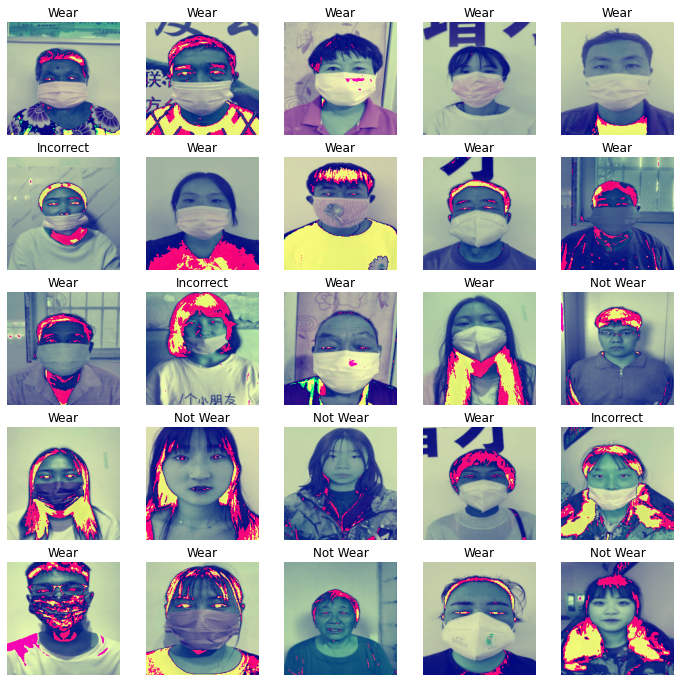

In [21]:
columns = 5
rows = 5
fig = plt.figure(figsize=(12,12))

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

#for i, (images, targets) in enumerate(train_loader) :
for i in range(1, columns*rows+1):
    #print(i)
    data_idx = np.random.randint(len(mask_train_data))
    #input_img = mask_train.dataset[data_idx][0].unsqueeze(dim=0).to(device)
    #print(input_img.shape)
    label = mask_train_data[data_idx][1]
    
    labels_map = {0:'Wear', 1:'Incorrect', 2:'Not Wear'}
    fig.add_subplot(rows, columns, i)
    pred_title = labels_map[label]
    plt.title(pred_title)
    
    plot_img = mask_train_data[data_idx][0]
    #print(plot_img.shape)
    # 이미지를 normalization 이전 상태로 되돌리는 작업
    plot_img[0, :, :] = plot_img[2, :, :] * std[2] + mean[2]
    plot_img[1, :, :] = plot_img[1, :, :] * std[1] + mean[1]
    plot_img[2, :, :] = plot_img[0, :, :] * std[0] + mean[0]
    plot_img = plot_img[:, 24:200, 24:200]
    plot_img = transforms.functional.to_pil_image(plot_img)
    #print(plot_img)
    plt.imshow(plot_img)
    plt.axis('off')
#plt.show()

### (2) Test Dataset

## 2. Model 정의

In [ ]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        super(TestDataset).__init__()
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [34]:
# 테스트 데이터셋 폴더 경로를 지정해주세요.
test_dir = '/opt/ml/input/data/eval'

In [ ]:
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
testimage_dir = os.path.join(test_dir, 'images')

In [36]:
# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(testimage_dir, img_id) for img_id in submission.ImageID]
transform = transforms.Compose([
    Resize((224, 224), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
])
test_dataset = TestDataset(image_paths, transform)

test_loader = DataLoader(
    test_dataset,
    shuffle=False
)

## 3. Training

In [49]:
learning_rate = 0.0015
betas = (0.9, 0.999)
weight_decay = 1e-4
T_max = 50

In [50]:
optimizer = optim.RAdam(model.parameters(), lr=learning_rate, betas=betas, weight_decay=weight_decay)
lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=T_max)

num_epochs = 30

valid_early_stop = 0
valid_best_loss = float('inf')
EARLY_STOPPING_EPOCH = 5
since = time.time()

final_train_loss = []
final_train_acc = []
final_valid_loss = []
final_valid_acc = []

for e in range(num_epochs) :
    print(f' ====================== epoch %d ======================' % (e+1) )
    train_loss_list = []
    train_acc_list = []
    epoch_f1 = 0
    n_iter = 0

    # train
    model.train()
    for i, (images, targets) in enumerate(train_loader) : 
        optimizer.zero_grad()

        images = images.to(device)
        targets = targets.to(device)

        scores = model(images)
        _, preds = scores.max(dim=1)

        loss = F.cross_entropy(scores, targets)
        loss.backward()
        optimizer.step()

        correct = sum(targets == preds).cpu()
        acc=(correct/images.shape[0] * 100)
        epoch_f1 += f1_score(preds.cpu().numpy(), targets.cpu().numpy(), average='macro')
        n_iter += 1

        train_loss_list.append(loss)
        train_acc_list.append(acc)

        if i % 50 == 0 :
            print(f'Iteration %3.d | Train Loss  %.4f | Classifier Accuracy %2.2f' % (i, loss, acc))

    train_mean_loss = np.mean(train_loss_list, dtype="float64")
    train_mean_acc = np.mean(train_acc_list, dtype="float64")

    final_train_loss.append(train_mean_loss)
    final_train_acc.append(train_mean_acc)
    
    epoch_f1 = epoch_f1/n_iter

    epoch_time = time.time() - since
    since = time.time()

    print('')
    print(f'[Summary] Elapsed time : %.0f m %.0f s' % (epoch_time // 60, epoch_time % 60))
    print(f'Train Loss Mean %.4f | Accuracy %2.2f | F1-Score %2.4f' % (train_mean_loss, train_mean_acc, epoch_f1) )

    # validation 
    model.eval()
    epoch_f1 = 0
    n_iter = 0
    valid_loss_list = []
    valid_acc_list = []
    for i, (images, targets) in enumerate(valid_loader) : 
        optimizer.zero_grad()
        images = images.to(device=device)
        targets = targets.to(device=device)

        with torch.no_grad():
            scores = model(images)
            loss = F.cross_entropy(scores, targets)
            _, preds = scores.max(dim=1)
            epoch_f1 += f1_score(preds.cpu().numpy(), targets.cpu().numpy(), average='macro')
            n_iter += 1

        correct = sum(targets == preds).cpu()
        acc=(correct/images.shape[0] * 100)

        valid_loss_list.append(loss)
        valid_acc_list.append(acc)

    val_mean_loss = np.mean(valid_loss_list, dtype="float64")
    val_mean_acc = np.mean(valid_acc_list, dtype="float64")

    final_valid_loss.append(val_mean_loss)
    final_valid_acc.append(val_mean_acc)
    
    epoch_f1 = epoch_f1/n_iter
    
    print(f'Valid Loss Mean %.4f | Accuracy %2.2f | F1-Score %2.4f' % (val_mean_loss, val_mean_acc, epoch_f1) )
    print('')

    if val_mean_loss < valid_best_loss:
        valid_best_loss = val_mean_loss
        valid_early_stop = 0
        # new best model save (valid 기준)
        best_model = model
        path = './model/'
        torch.save(best_model.state_dict(), f'{path}model{val_mean_acc:2.2f}_epoch_{e}.pth')
    else:
        # early stopping    
        valid_early_stop += 1
        if valid_early_stop >= EARLY_STOPPING_EPOCH:
            print("EARLY STOPPING!!")
            break

    lr_sched.step()

 ====================== epoch 1 ======================
Iteration   0 | Train Loss  3.2749 | Classifier Accuracy 6.25
Iteration  50 | Train Loss  0.5818 | Classifier Accuracy 71.88
Iteration 100 | Train Loss  0.6979 | Classifier Accuracy 81.25
Iteration 150 | Train Loss  0.5630 | Classifier Accuracy 84.38
Iteration 200 | Train Loss  0.3578 | Classifier Accuracy 84.38
Iteration 250 | Train Loss  0.2055 | Classifier Accuracy 90.62
Iteration 300 | Train Loss  0.3133 | Classifier Accuracy 84.38
Iteration 350 | Train Loss  0.3258 | Classifier Accuracy 87.50
Iteration 400 | Train Loss  0.1600 | Classifier Accuracy 96.88
Iteration 450 | Train Loss  0.2002 | Classifier Accuracy 90.62

[Summary] Elapsed time : 1 m 17 s
Train Loss Mean 0.5693 | Accuracy 81.97 | F1-Score 0.6903
Valid Loss Mean 0.6930 | Accuracy 76.52 | F1-Score 0.6677

 ====================== epoch 2 ======================
Iteration   0 | Train Loss  0.1695 | Classifier Accuracy 96.88
Iteration  50 | Train Loss  0.2071 | Classifie

## 4. Inference

In [51]:
best_model.eval()
# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in test_loader:
    with torch.no_grad():
        images = images.to(device)
        scores = best_model(images)
        preds = scores.argmax(dim=-1)
        all_predictions.extend(preds.cpu().numpy())

In [52]:
len(all_predictions)

12600

In [53]:
from collections import Counter
Counter(all_predictions)

Counter({13: 490,
         1: 2471,
         12: 436,
         0: 1770,
         8: 124,
         4: 1975,
         3: 2084,
         6: 446,
         2: 341,
         7: 589,
         16: 355,
         14: 128,
         9: 366,
         10: 386,
         15: 347,
         5: 206,
         11: 32,
         17: 54})

In [54]:
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission_baseline4_allinone.csv'), index=False)
print('test inference is done!')

test inference is done!
